First things first. We need to import all the needed [modules](https://docs.python.org/3/reference/import.html) for this project. Below, I've made a list and described each module and included a link for its website. Typically, to follow along, you just need to `pip install` any of these (for example, `pip install matplotlib`), unless you are using a version of [Anaconda](https://www.anaconda.com/), in which case, you can use `conda install` for any of these modules.

# Modules
- [Numpy](http://www.numpy.org/) is an incredibly powerful tool that is used almost everywhere you encounter matrices in Python. We also use it mainly for its powerful operations on their N-dimensional array objects.

- [Pandas](https://pandas.pydata.org/) is a must for data science in Python. It handles powerful, expressive, and flexible data structures that allow easy data manipulation and analysis (among other things). Main thing to take away are the DataFrames.
- [StatsModels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It complements SciPy computations providing descriptive statistics and estimation and inference for statistical models.
- [SciPy](https://www.scipy.org/) contains modules for optimization, linear algebra, integration, interpoliation, and much more. Here we will use it mainly for _______.
- [SkLearn](http://scikit-learn.org/stable/) is a Python module for machine learning built on top of SciPy 
- [Math](https://docs.python.org/3/library/math.html) is avaiable by default (i.e. no need to install separately!). This module includes common mathematical functions.
- [Random](https://docs.python.org/3/library/random.html) is a module that generates psuedo-random numbers from various distributions. 
- [Keras](https://keras.io/) is an open source neural network library.
- [Matplotlib](https://matplotlib.org/) is a plotting library. If you're familiar with MATLAB, then this should be familiar as well.
- [Plotly](https://plot.ly/python/) is an interactive, open-source, and browser-based graphing library for Python.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# Data

Now we load up the data and do a little bit of data wrangling. We will load the data into a pandas dataframe and make sure of the following:
1. there are no nulls (if there are, we can figure out what to do then),
2. the format of the data is acceptable (i.e. datetime)
3. bin data as necessary (data will probably come to us in minute/hourly data given the nature of the machine-generated financial data) so we will need to bin the data (for now, we will go with daily updates).

In [2]:
# Let's load up the data into pandas dataframe called data
data = pd.read_csv('./bitcoin.csv')

# We can double check the type of data. It should be dataframe.
type(data)

pandas.core.frame.DataFrame

Great!

Data is loaded into `data`. Note that since we used `pd` (i.e. `pandas`), data is a pandas DataFrame.

As with any data science project, we need to get familar with our data. Let's take a **(1) look at the data** and **(2) clean the data as needed**.
- Check to see if any values are null in the dataframe. Keep in mind, we are looking at financial data that is machine generated, so we're unlikely to have any null values. If we do have any, it would be easy to fill in the gaps using a simple interpolation, but we'll cross that bridge if we have to.
- Take a look at the top 10 rows to look at the value and get a sense of what the data looks like.
- Scale data as needed.

In [3]:
# Are any data points null?
data.isnull().values.any()

False

In [4]:
# What does the first 10 rows look like?
data.head(5)

,Date,High,Low,Last,Bid,Ask,Volume,VWAP
0,2019-03-18,4016.63,3929.83,3975.87,3973.31,3975.88,5396.002160,3967.67
1,2019-03-17,3992.70,3927.28,3968.87,3968.14,3969.50,2766.650623,3962.73
2,2019-03-16,4040.00,3890.97,3984.76,3984.76,3985.00,6961.197358,3982.41
3,2019-03-15,3912.06,3843.09,3889.88,3889.92,3892.16,6452.389692,3878.79
4,2019-03-14,3903.98,3775.01,3852.77,3852.77,3853.50,5094.581868,3848.17


Let's take note of a few things:

1. Take a look at the timestamp. The number you see is a Unix timestamp that captures the number of seconds since epoch (considered to be 1970-01-01 12AM). 
Take for instance, the first row (1325317980). That is equivalent to Saturday, December 31, 2011 7:52:00 AM (GMT) and the second row (1325317980) is the same as Saturday, December 31, 2011 7:53:00 AM. Mainly, notice that it is in the same day. So for the time being, we will look at data partitioned by day, so we're going to need to get the average price grouped by the day.
2. We want to change the timestamp into a human readable datetime format.

In [5]:
#First we create a new column called "date" then we group by and grab the average
group = data.groupby('Date')
Daily_Price = group['Last'].mean()

# let's take a look at the first 5
Daily_Price.head()

Date
2014-04-15    499.01
2014-04-16    534.00
2014-04-17    506.52
2014-04-18    487.00
2014-04-19    504.74
Name: Last, dtype: float64

In [6]:
#and the last 5
Daily_Price.tail()

Date
2019-03-14    3852.77
2019-03-15    3889.88
2019-03-16    3984.76
2019-03-17    3968.87
2019-03-18    3975.87
Name: Last, dtype: float64

## Split our dataset

We need to **split our dataset** because we want to train and test the model only on some chunk of the data. So, in the next cell, we are counting the necessary parameters for splitting (number of days between some dates). We want to train our model on the data from January 1, 2016, until March 1, 2018, and to test the model on the data from March 1, 2018, until June 27, 2018.

In [8]:
from datetime import date

d0 = date(2015, 1, 1)
d1 = date(2019, 3, 18)
delta = d1 - d0
days_look = delta.days + 1
print("days between", d0, "and", d1, ":", days_look)

d0 = date(2015, 1, 1)
d1 = date(2019, 1, 1)
delta = d1 - d0
days_from_train = delta.days + 1
print("days between", d0, "and", d1, ":", days_from_train)

d0 = date(2019, 3, 18)
d1 = date(2019, 3, 18)
delta = d1 - d0
days_from_end = delta.days + 1
print("days between", d0, "and", d1, ":", days_from_end)

days between 2015-01-01 and 2019-03-18 : 1538
days between 2015-01-01 and 2019-01-01 : 1462
days between 2019-03-18 and 2019-03-18 : 1


In [45]:
#Now we are splitting our data into the train and test set:

df_train= Daily_Price[:days_from_train]
df_test= Daily_Price[days_from_train:]

# Just as a sanity-checlek, 

#np.array(df_test.values)

# Cursory Data Analysis

We want to estimate some parameters of our data because this can be useful in the further model designing. The first important thing when forecasting time series is to check if the data is stationary. This means that our data is influenced by such factors as trend or seasonality.

In the next cell, we concatenate train and test data to make analysis and transformations simultaneously.

In [46]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
#working_data['date'] = working_data['Date']
working_data = working_data.set_index('Date')

### Seasonal Decomposition

Next, we will perform a seasonal decomposition on the data (inevitable given the breadth and category of the data we are workign with) to estimate its trend and seasonality. We will plot it all out so we can see the actual price movements on the plot below (“observed”) as well as the trend and seasonality in our data.

We will be using `seasonal_decompose` function which is a part of the `time series analysis (tsa)` in `statsmodel`. Click [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to read more about it.

Further, as mentioned above, we will be using plot.ly's line and scatter plots, which you can read more about [here](https://plot.ly/python/line-and-scatter/).

In [47]:
s = sm.tsa.seasonal_decompose(working_data.Last.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),
                    y = s.trend,mode = 'lines',
                    name = 'Trend',
                    line = dict(color = ('rgb(244, 93, 1)'), width = 2)
                   )

trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),
                    y = s.seasonal,mode = 'lines',
                    name = 'Seasonal',
                    line = dict(color = ('rgb(238, 185, 2)'),width = 2)
                   )

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),
                    y = s.resid,mode = 'lines',
                    name = 'Residual',
                    line = dict(color = ('rgb(151, 204, 4)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),
                    y = s.observed,mode = 'lines',
                    name = 'Observed',
                    line = dict(color = ('rgb(45, 125, 210)'), width = 2))

data = [trace1, trace2, trace3, trace4]

layout = dict(title = 'Seasonal decomposition',
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Price, USD')
             )

fig = dict(data=data,
           layout=layout)

py.iplot(fig, filename='seasonal_decomposition')

### Autocorrelation

Next, we need to look at the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation).


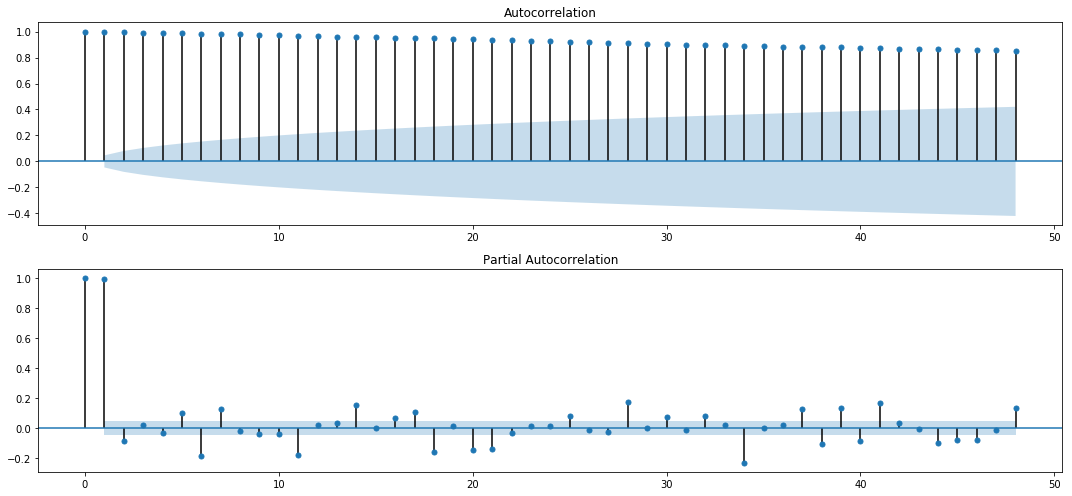

In [48]:

plt.figure(figsize=(15,7))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Last.values.squeeze(),
                         lags=48,
                         ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Last.values.squeeze(),
                          lags=48,
                          ax=ax)

plt.tight_layout()
plt.show()

# Data Preparation

We need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts. In the next cell, we define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of these values we can set by tuning the parameter look_back in our function. If we set it to 1, this means that we predict current value t based on the previous value (t-1).



In [50]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

Now we perform final data preparation:

Reshape the train and test datasets according to the requirements of the model.
Scale the dataset by using the MinMaxScaler because LSTM models are scale sensitive.
Apply our create_lookback function.

In [62]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# Training 2-layers LSTM Neural Network

Eventually, we can build and train our model. We use Keras framework for deep learning. Our model consists of two stacked LSTM layers with 256 units each and the densely connected output layer with one neuron. We are using Adam optimizer and MSE as a loss. Also, we use an early stopping if the result doesn't improve during 20 training iterations (epochs). We performed several experiments and found that the optimal number of epochs and butch_size is 100 and 16 respectively. Also, it is important to set shuffle=False because we don't want to shuffle time series data.

In [75]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, 
               return_sequences=True, 
               input_shape=(X_train.shape[1], 
                            X_train.shape[2]
                           )
              )
         )
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(X_train,
                    Y_train, 
                    epochs=100, 
                    batch_size=16, 
                    shuffle=False,  
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 1461 samples, validate on 312 samples
Epoch 1/100
1461/1461 [==============================] - 3s 2ms/step - loss: 0.0267 - val_loss: 0.1785
Epoch 2/100
1461/1461 [==============================] - 1s 875us/step - loss: 0.0675 - val_loss: 0.1486
Epoch 3/100
1461/1461 [==============================] - 1s 912us/step - loss: 0.0962 - val_loss: 0.0633
Epoch 4/100
1461/1461 [==============================] - 1s 919us/step - loss: 0.0623 - val_loss: 0.0623
Epoch 5/100
1461/1461 [==============================] - 1s 884us/step - loss: 0.0444 - val_loss: 0.0954
Epoch 6/100
1461/1461 [==============================] - 1s 890us/step - loss: 0.0414 - val_loss: 0.0241
Epoch 7/100
1461/1461 [==============================] - 1s 851us/step - loss: 0.0338 - val_loss: 0.0970
Epoch 8/100
1461/1461 [==============================] - 1s 849us/step - loss: 0.0369 - val_loss: 0.0735
Epoch 9/100
1461/1461 [==============================] - 1s 903us/step - loss: 0.0370 - val_loss: 0.0801
Epoch 10/1

In [76]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

We trained our model. You can see that it has good performance even after several iterations. On the plot above, we compare the Train and Test loss on each iteration of the training process. We can see, that after some iterations train and test loss become very similar, which is a good sign (this means we are not overfitting the train set). Below, we use our model to predict labels for the test set. Then we inverse original scale of our data. You can see a comparison of true and predicted labels on the chart below. It looks like our model gives good results (lines are very similar)!



In [80]:
# add one additional data point to align shapes of the predictions and true labels
#X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0].reshape(-1,1)))
#X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD

prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [91]:

trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

import plotly.io as pio

pio.write_image(fig, file='btc.png', format='png')